In [1]:
%matplotlib inline
import torchvision
import torchvision.datasets as dset
import torchvision.transforms as transforms
from torch.utils.data import DataLoader, Dataset
import matplotlib.pyplot as plt
import torchvision.utils
import numpy as np
import random
from PIL import Image
import torch
from torch.autograd import Variable
import PIL.ImageOps    
import torch.nn as nn
from torch import optim
import torch.nn.functional as F
from torch.optim.lr_scheduler import ReduceLROnPlateau
import copy
import os

os.environ['KMP_DUPLICATE_LIB_OK']='True'

In [2]:
class Config():
    # training_dir = "D:/data/training/"
    # testing_dir = "D:/data/testing/"
    # validation_dir = "D:/data/validation/"
    # db_dir = "D:/data/db/"
    
    training_dir = "D:/non_bg/training/"
    testing_dir = "D:/non_bg/testing/"
    validation_dir = "D:/non_bg/validation/"
    db_dir = "D:/non_bg/db/"

    train_batch_size = 64
    train_number_epochs = 100

In [3]:
def imshow(img, text=None, should_save=False):
    npimg = img.numpy()
    plt.axis("off")
    if text:
        plt.text(75, 8, text, style='italic', fontweight='bold',
            bbox={'facecolor': 'white', 'alpha': 0.8, 'pad': 10})
    plt.imshow(np.transpose(npimg, (1,2,0)))
    plt.show()    

def show_plot(iteration, loss):
    plt.plot(iteration, loss)
    plt.show()

In [4]:
class SiameseNetworkDataset(Dataset):
    
    def __init__(self, imageFolderDataset, transform=None, should_invert=True, testing=False):
        self.imageFolderDataset = imageFolderDataset    
        self.transform = transform
        self.should_invert = should_invert
        self.testing = testing

    def rotate(self, img):
        try:
            if img._getexif()[274] not in [1, 2]:
                orientation = img._getexif()[274]
                
                if orientation == 2:
                    img = img.transpose(Image.FLIP_LEFT_RIGHT)

                elif orientation == 3:
                    img = img.rotate(180)

                elif orientation == 4:
                    img = img.rotate(180).transpose(Image.FLIP_LEFT_RIGHT)

                elif orientation == 5:
                    img = img.rotate(-90, expand=True).transpose(Image.FLIP_LEFT_RIGHT)

                elif orientation == 6:
                    img = img.rotate(-90, expand=True)

                elif orientation == 7:
                    img = img.rotate(90, expand=True).transpose(Image.FLIP_LEFT_RIGHT)
            
            return img
        except:
            return img
        
    def __getitem__(self, index):
        img0_tuple = random.choice(self.imageFolderDataset.imgs)
        #we need to make sure approx 50% of images are in the same class
        should_get_same_class = random.randint(0,1) 
        if should_get_same_class:
            while True:
                #keep looping till the same class image is found
                img1_tuple = random.choice(self.imageFolderDataset.imgs) 
                if img0_tuple[1] == img1_tuple[1]:
                    break
        else:
            while True:
                #keep looping till a different class image is found
                
                img1_tuple = random.choice(self.imageFolderDataset.imgs) 
                if img0_tuple[1] != img1_tuple[1]:
                    break

        img0 = Image.open(img0_tuple[0])
        img1 = Image.open(img1_tuple[0])

        if img0._getexif() not in [1, 2]:
            img0 = self.rotate(img0)
        
        if img1._getexif() not in [1, 2]:
            img1 = self.rotate(img1)

        img0 = img0.convert("L")
        img1 = img1.convert("L")
        
        if self.should_invert:
            img0 = PIL.ImageOps.invert(img0)
            img1 = PIL.ImageOps.invert(img1)

        if self.transform is not None:
            img0 = self.transform(img0)
            img1 = self.transform(img1)
        
        if self.testing:
            name = img0_tuple[0]
            return img0, img1, torch.from_numpy(np.array( [int(img1_tuple[1]!=img0_tuple[1])], dtype=np.float32 )), name

        return img0, img1, torch.from_numpy(np.array( [int(img1_tuple[1]!=img0_tuple[1])], dtype=np.float32 ))
    
    def __len__(self):
        return len(self.imageFolderDataset.imgs)

In [5]:
class DB_Dataset():
    def __init__(self, path, transform=None, should_invert=True):
        self.path = path
        self.transform = transform
        self.should_invert = should_invert

    def rotate(self, img):
        try:
            if img._getexif()[274] not in [1, 2]:
                orientation = img._getexif()[274]
                
                if orientation == 2:
                    img = img.transpose(Image.FLIP_LEFT_RIGHT)

                elif orientation == 3:
                    img = img.rotate(180)

                elif orientation == 4:
                    img = img.rotate(180).transpose(Image.FLIP_LEFT_RIGHT)

                elif orientation == 5:
                    img = img.rotate(-90, expand=True).transpose(Image.FLIP_LEFT_RIGHT)

                elif orientation == 6:
                    img = img.rotate(-90, expand=True)

                elif orientation == 7:
                    img = img.rotate(90, expand=True).transpose(Image.FLIP_LEFT_RIGHT)
            
            return img
        except:
            return img

    def __getitem__(self, index):
        name = os.listdir(self.path)[index]
        img = Image.open(self.path + name)

        if img._getexif() not in [1, 2]:
            img = self.rotate(img)

        img = img.convert("L")
        
        if self.should_invert:
            img = PIL.ImageOps.invert(img)

        if self.transform is not None:
            img = self.transform(img)

        return img, name
    
    def __len__(self):
        return len(os.listdir(self.path))

In [6]:
# SiameseNetwork
class SiameseNetwork(nn.Module):
    def __init__(self):
        super(SiameseNetwork, self).__init__()
        self.cnn1 = nn.Sequential(
            nn.Conv2d(1, 16, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(16, 16, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(2, 2),            

            nn.Conv2d(16, 32, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(32, 32, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(2, 2), 

            nn.Conv2d(32, 64, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(64, 64, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(2, 2),

            nn.Conv2d(64, 128, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(128, 128, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(2, 2),

            nn.Conv2d(128, 256, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(256, 256, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(2, 2),  
            
            nn.Dropout(0.4)
        )

        self.fc1 = nn.Sequential(
            nn.Linear(36*8*8, 512),
            nn.ReLU(inplace=True),
            # nn.Dropout(),
            
            nn.Linear(512, 256),
            nn.ReLU(inplace=True),
            # nn.Dropout(),
            
            nn.Linear(256, 5))

    def forward_once(self, x):
        output = self.cnn1(x)
        output = output.view(output.size()[0], -1)
        output = self.fc1(output)
        return output

    def forward(self, input1, input2):
        output1 = self.forward_once(input1)
        output2 = self.forward_once(input2)
        return output1, output2

In [7]:
class ContrastiveLoss(torch.nn.Module):

    def __init__(self, margin=2.0):
        super(ContrastiveLoss, self).__init__()
        self.margin = margin

    def forward(self, output1, output2, label):
        euclidean_distance = F.pairwise_distance(output1, output2, keepdim = True)
        loss_contrastive = torch.mean((1-label) * torch.pow(euclidean_distance, 2) +
                                      (label) * torch.pow(torch.clamp(self.margin - euclidean_distance, min=0.0), 2))

        return loss_contrastive

In [8]:
# Early Stopping을 위해 validation loss를 계산하는 함수
def calculate_validation_loss(model, dataloader, criterion):
    total_loss = 0.0
    total_samples = 0

    model.eval()  # 모델을 평가 모드로 설정

    with torch.no_grad():
        for data in dataloader:
            inputs1, inputs2, labels = data
            inputs1 = inputs1.cuda()
            inputs2 = inputs2.cuda()
            labels = labels.cuda()

            outputs1, outputs2 = model(inputs1, inputs2)
            loss = criterion(outputs1, outputs2, labels)

            total_loss += loss.item()*inputs1.size(0)
            total_samples += inputs1.size(0)

    average_loss = total_loss / total_samples

    return average_loss

In [9]:
#training_dir 경로 안의 모든 파일을 폴더명과 함께 튜플로 저장
folder_dataset = dset.ImageFolder(root=Config.training_dir)

In [10]:
siamese_dataset = SiameseNetworkDataset(imageFolderDataset=folder_dataset,
                                        transform=transforms.Compose([transforms.Resize((100,100)),
                                                                      transforms.ToTensor()]),
                                        should_invert=False)

In [11]:
train_dataloader = DataLoader(siamese_dataset, shuffle=True, num_workers=0, batch_size=Config.train_batch_size)

In [12]:
# validation 데이터셋
folder_dataset_val = dset.ImageFolder(root=Config.validation_dir)
siamese_dataset_val = SiameseNetworkDataset(imageFolderDataset=folder_dataset_val,
                                            transform=transforms.Compose([transforms.Resize((100, 100)),
                                                                          transforms.ToTensor()]),
                                            should_invert=False)
validation_dataloader = DataLoader(siamese_dataset_val, num_workers=0, batch_size=16)

In [13]:
net = SiameseNetwork().cuda()
criterion = ContrastiveLoss()

In [ ]:
# Early Stopping과 Model Checkpoint를 위한 변수 설정
patience = 7  # 검증 손실이 감소하지 않아도 참을 수 있는 epoch 수
early_stopping_counter = 0
best_loss = float('inf')
best_model = None
best_model_state = None
checkpoint_path = './model_checkpoint.pt'
train_loss_history = []
val_loss_history = []

# Optimizer와 Scheduler 설정
optimizer = optim.Adam(net.parameters(), lr=0.0005)
scheduler = ReduceLROnPlateau(optimizer, patience=patience, factor=0.1, verbose=True)

# 학습
for epoch in range(0, Config.train_number_epochs):
    temp = []
    for i, data in enumerate(train_dataloader, 0):
        img0, img1, label = data
        img0, img1, label = img0.cuda(), img1.cuda(), label.cuda()
        optimizer.zero_grad()
        output1, output2 = net(img0, img1)
        loss_contrastive = criterion(output1, output2, label)
        loss_contrastive.backward()
        optimizer.step()
        temp.append(loss_contrastive.item())
    
    # 훈련용 데이터 오차
    train_loss = np.mean(temp)
    train_loss_history.append(train_loss)

    # 검증용 데이터로 성능 평가
    val_loss = calculate_validation_loss(net, validation_dataloader, criterion)
    val_loss_history.append(val_loss)

    print("Epoch {}\n training loss: {:.7f}\n validation loss: {:.7f}".format(epoch+1, train_loss, val_loss))

    # 검증 손실이 더 좋아지지 않으면 카운터 증가
    if val_loss >= best_loss:
        early_stopping_counter += 1

        # 학습 조기 종료 조건 확인
        if early_stopping_counter == patience:
            print("Early Stopping: Training stopped due to no improvement in validation loss.")
            break
    
    # 현재 검증 손실이 최저 손실보다 낮으면 모델 저장
    else:
        early_stopping_counter = 0
        
        best_loss = val_loss
        best_model_state = copy.deepcopy(net.state_dict())
        
        # Save checkpoint
        torch.save(best_model_state, checkpoint_path)
        print('Saved model')
   
# Plot the training and validation losses
plt.plot(range(len(train_loss_history)), train_loss_history, label='Training Loss')
plt.plot(range(len(val_loss_history)), val_loss_history, label='Validation Loss')
plt.xlabel('Iterations')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [15]:
# Load the best model from checkpoint
checkpoint = torch.load('./model_checkpoint.pt')
net.load_state_dict(checkpoint)

<All keys matched successfully>

In [16]:
# DB 이미지 로드
db_dataset = DB_Dataset(path=Config.db_dir, 
                        transform=transforms.Compose([transforms.Resize((100,100)),
                                                      transforms.ToTensor()]), 
                        should_invert=False)
db_dataloader = DataLoader(db_dataset, num_workers=0, batch_size=1, shuffle=False)

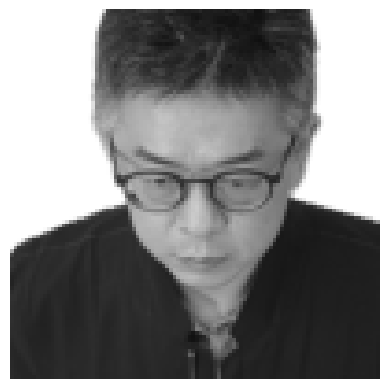

1013003


In [25]:
# 테스트용 사진 선택
folder_dataset_test = dset.ImageFolder(root=Config.testing_dir)
siamese_dataset = SiameseNetworkDataset(imageFolderDataset=folder_dataset_test,
                                        transform=transforms.Compose([transforms.Resize((100,100)),
                                                                      transforms.ToTensor()]), 
                                        should_invert=False,
                                        testing=True)
test_dataloader = DataLoader(siamese_dataset, num_workers=0, batch_size=1, shuffle=True)

dataiter = iter(test_dataloader)
x0, _, _, img_name = next(dataiter)
img_name = img_name[0].split('/')[-1].split('\\')[0]
imshow(torchvision.utils.make_grid(x0))
print(img_name)

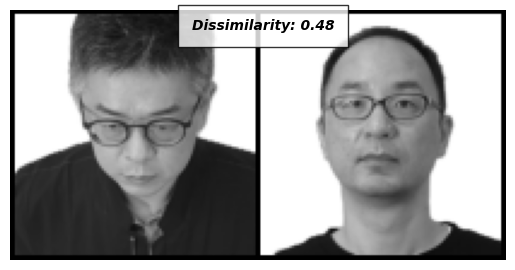

test iamge name: 1013003.jpg 	   database image name: 1008001.jpg


In [26]:
# DB에서 일치하는 사진 탐색
torch.cuda.manual_seed(1)
dataiter = iter(db_dataloader)
min_distance = np.inf
idx=0
for i in range(db_dataset.__len__()):
    
    x1, label = next(dataiter)
    concatenated = torch.cat((x0,x1), 0)
    
    output1, output2 = net(Variable(x0).cuda(), Variable(x1).cuda())
    euclidean_distance = F.pairwise_distance(output1, output2)
    
    if euclidean_distance <= min_distance:
        min_distance = euclidean_distance
        imgset = concatenated
        name = label[0]

if min_distance.item() <= 0.7:
    imshow(torchvision.utils.make_grid(imgset), 'Dissimilarity: {:.2f}'.format(min_distance.item()))
    print(f'test iamge name: {img_name}.jpg \t   database image name: {name}')
else:
    print('none')